# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**

* *Kenza Driss*
* *Maximilien Hoffbeck*
* *Jaeyi Jeong*
* *Yoojin Kim*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [21]:
# ... WRITE YOUR CODE HERE...
import networkx as nx
import random
import matplotlib.pyplot as plt

In [22]:
def random_surfer(G, num_iters=100000):
    # initial states
    node_cnt = {node: 0 for node in G.nodes()}
    current_node = random.choice(list(G.nodes()))
    # random surfing
    for _ in range(num_iters):
        node_cnt[current_node] += 1
        neighbors = list(G.neighbors(current_node))
        if neighbors: 
            current_node = random.choice(neighbors)
    # normalization
    sum_cnt = sum(node_cnt.values())
    scores = {node: cnt/sum_cnt for node, cnt in node_cnt.items()}

    return scores

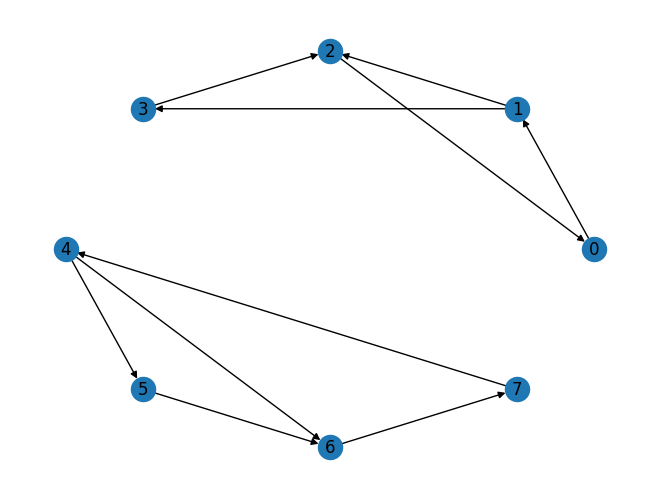

In [23]:
C = nx.read_adjlist("../data/components.graph", create_using=nx.DiGraph(), nodetype=int)
nx.draw(C, with_labels=True, pos=nx.circular_layout(C))
plt.show()

In [24]:
C_rs = random_surfer(C)
for node, score in sorted(C_rs.items()):
    print(f"{node}: {score:.4f}")

0: 0.2858
1: 0.2858
2: 0.2858
3: 0.1425
4: 0.0000
5: 0.0000
6: 0.0000
7: 0.0000


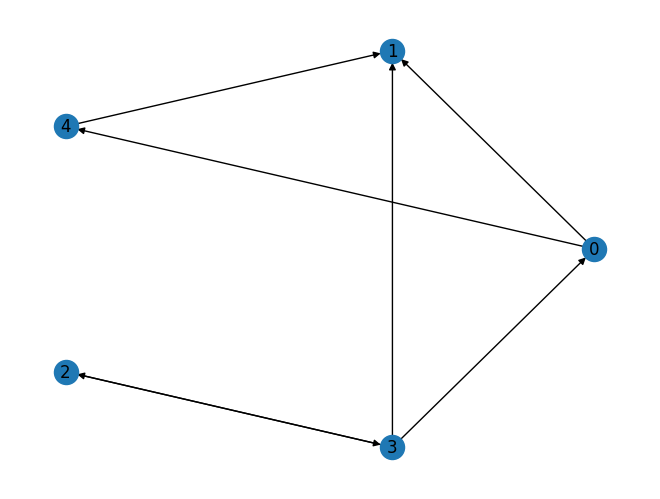

In [25]:
A = nx.read_adjlist("../data/absorbing.graph", create_using=nx.DiGraph(), nodetype=int)
nx.draw(A, with_labels=True, pos=nx.circular_layout(A))
plt.show()

In [26]:
A_rs = random_surfer(A)
for node, score in sorted(A_rs.items()):
    print(f"{node}: {score:.4f}")

0: 0.0000
1: 1.0000
2: 0.0000
3: 0.0000
4: 0.0000


##### Observations:
1. For components.graph:
- Only some nodes earned a score, while others had a score of 0. This indicates that some nodes were never visited by the random surfer.
- The graph consists of two disconnected components. Since the random surfer starts in one component and never moves to the other, nodes in the isolated component are never reached.
2. For absorbing.graph:
- Node 1 has earned a score of 1, while all other nodes (0,2,3,4) have scores of 0. This indicates that node 1 is an absorbing node, so that once the random surfer reaches it, they cannot leave.
- The graph has directed edges that lead to node 1, but there are no outgoing edges from node 1. This is why the random surfer is absorbed there and cannot transition to any other node, resulting in a score of 0 for all other nodes.

#### Exercise 2.13

In [27]:
def random_surfer_plus(G, num_iters=100000, damping_factor=0.15):
    # initial states
    node_cnt = {node: 0 for node in G.nodes()}
    current_node = random.choice(list(G.nodes()))
    # random surfing
    for _ in range(num_iters):
        node_cnt[current_node] += 1
        # random restart
        if random.random() < damping_factor:
            current_node = random.choice(list(G.nodes()))
        else:
            neighbors = list(G.neighbors(current_node))
            if neighbors: 
                current_node = random.choice(neighbors)
            else:   # dangling nodes    
                current_node = random.choice(list(G.nodes()))
    # normalization
    sum_cnt = sum(node_cnt.values())
    scores = {node: cnt/sum_cnt for node, cnt in node_cnt.items()}

    return scores

In [28]:
C_rs_plus = random_surfer_plus(C)
for node, score in sorted(C_rs_plus.items()):
    print(f"{node}: {score:.4f}")

0: 0.1413
1: 0.1388
2: 0.1451
3: 0.0771
4: 0.1377
5: 0.0769
6: 0.1426
7: 0.1403


In [29]:
A_rs_plus = random_surfer_plus(A)
for node, score in sorted(A_rs_plus.items()):
    print(f"{node}: {score:.4f}")

0: 0.1482
1: 0.3381
2: 0.1486
3: 0.2139
4: 0.1512


##### Observations:
1. For components.graph:
- Previously, only the nodes from one component owned the scores, while the others couldn't. However, the new model produces scores that are more evenly distributed across the nodes. 
- This implies that no single node stands out noticeably, and the graph is likely more balanced and connected, allowing the random surfer to visit most nodes with a similar probability.

2. For absorbing.graph:
- The previous model had a very skewed result, with node 1 having a score of 1 and all other nodes having a score of 0. The new model produces a less extreme but still somewhat uneven distribution, with node 1 having a significantly higher score than the others.
- While node 1 still has a dominant influence, the result reflects a more distributed set of scores. This indicates that, although node 1 remains the most visited node, the others also have some chance of being visited, aligning with the absorbing nature of the graph but allowing for more diversity in visits.

Overall, the PageRank scores reflect the structure and properties of the graphs well. 

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [30]:
import numpy as np
import pandas as pd

In [31]:
def power_iteration(W, num_iters=100, theta=0.85):
    N = len(W.nodes())
    H = np.zeros((N,N)) # transition matrix of Markov chain
    w = np.zeros(N)     # indicator vector of dangling nodes
    for u in W.nodes():
        o_u = len(list(W.neighbors(u))) # out-degree
        if o_u > 0:
            for v in W.neighbors(u):
                H[u,v] = 1 / o_u
        else:
            w[u] = 1
    # new transition matrix
    hH = H + w * np.ones((N,N)) / N
    # Google matrix (final transition matrix)
    G = theta * hH + (1 - theta) * np.ones((N,N)) / N
    # power iteration
    pi = np.ones(N) / N
    for _ in range(num_iters):
        pi = np.dot(pi, G)
    return pi

In [32]:
W = nx.read_adjlist("../data/wikipedia.graph", create_using=nx.DiGraph(), nodetype=int)
titles_df = pd.read_csv("../data/wikipedia_titles.tsv", sep="\t")

pi = power_iteration(W)
print(pi)

[3.19552873e-04 7.67467833e-05 2.32565260e-04 ... 7.75919655e-05
 1.10307127e-04 1.24601074e-04]


Top 10 pages with the highest PageRank score:

In [33]:
top_10_idx = np.argsort(pi)[::-1][:10]
top_10_score = pi[top_10_idx]
for idx, score in zip(top_10_idx, top_10_score):
    title = titles_df['page_title'][idx]
    print(f"{title}({idx}): {score}")

United States(5210): 0.0074240193195802
United Kingdom(5201): 0.005140359547570368
France(2034): 0.004963502958385187
Europe(1890): 0.004448877397226289
Germany(2168): 0.00393375111519465
England(1811): 0.003821978828596903
World War II(5477): 0.0036944134035460626
Latin(2999): 0.0035815430440332115
India(2619): 0.003566779815789679
English language(1818): 0.0033547261021276025


---

### 2.4.3 Gaming the system *(Bonus)*

#### Exercise 2.15 *(Bonus)*

Original PageRank score of the page

In [34]:
hom_idx = titles_df[titles_df['page_title'] == "History of mathematics"].index[0]
hom_score = pi[hom_idx]
print(hom_score)

9.799781389032635e-05


Strategy 1. Add 300 edges from high PageRank score pages

In [35]:
W1 = W.copy()
print(f"Before adding edges: {len(W1.edges())}")
sorted_idx = np.argsort(pi)[::-1]
added = 0
for idx in sorted_idx:
    if added >= 300:
        break
    if not W1.has_edge(idx, hom_idx):
        W1.add_edge(idx, hom_idx)
        added += 1
print(f"After adding edges: {len(W1.edges())}")

pi1 = power_iteration(W1)
score1 = pi1[hom_idx]
print(f"1. {score1}")

Before adding edges: 197056
After adding edges: 197356
1. 0.004638020869685655


- This strategy adds edges from high PageRank nodes, assuming that connecting to high-ranked pages would increase the 'History of mathematics' page.
- It first sorts pages by their current PageRank score in descending order, and then adds edges. 
- The score increased to approximately 0.0046.

Strategy 2. Add 300 edges from high in-degree pages

In [36]:
W2 = W.copy()
print(f"Before adding edges: {len(W2.edges())}")
sorted_in_idx = sorted(W2.in_degree(), key=lambda x: x[1], reverse=True)
added = 0
for idx, _ in sorted_in_idx:
    if added >= 300:
        break
    if not W2.has_edge(idx, hom_idx):
        W2.add_edge(idx, hom_idx)
        added += 1
print(f"After adding edges: {len(W2.edges())}")

pi2 = power_iteration(W2)
score2 = pi2[hom_idx]
print(f"2. {score2}")

Before adding edges: 197056
After adding edges: 197356
2. 0.004051981437812623


- This strategy add edges from nodes with high in-degrees, which means these nodes are already well connected in the graph. Adding links from them might help spread the influence more effectively.
- The score has improved, but the effect was less significant compared to the first method.

Strategy 3. Add 300 edges from high score & low out-degree pages

In [37]:
W3 = W.copy()
print(f"Before adding edges: {len(W3.edges())}")
sorted_idx = np.argsort(pi)[::-1]
added = 0
for idx in sorted_idx:
    if added >= 300:
        break
    if W3.out_degree(idx) < 30:
        if not W3.has_edge(idx, hom_idx):
            W3.add_edge(idx, hom_idx)
            added += 1
print(f"After adding edges: {len(W3.edges())}")

pi3 = power_iteration(W3)
score3 = pi3[hom_idx]
print(f"3. {score3}")

Before adding edges: 197056
After adding edges: 197356
3. 0.005319341962411789


- This strategy adds edges from nodes that have a high PageRank but a low out-degree. It sorts nodes based on their PageRank in descending order, and then selects nodes with low out-degree (less than 30).
- The reason for selecting low out-degree nodes is that even if a node has a high PageRank, if its out-degree is large, adding an edge to the target page might not significantly increase the likelihood of passing through that node's path. By restricting the out-degree, we ensure that the added edges are more likely to help the target page gain the score.
- The resulted score is much better than the previous two methods. (approximately 0.0053) 

Strategy 3+. Use a fixed threshold

In [38]:
W33 = W.copy()
print(f"Before adding edges: {len(W33.edges())}")
out_degrees = np.array([W33.out_degree(n) for n in W33.nodes()])
threshold = np.percentile(out_degrees, 50)
added = 0
for idx in sorted_idx:
    if added >= 300:
        break
    if W33.out_degree(idx) < threshold:
        if not W33.has_edge(idx, hom_idx):
            W33.add_edge(idx, hom_idx)
            added += 1
print(f"After adding edges: {len(W33.edges())}")

pi33 = power_iteration(W33)
score33 = pi33[hom_idx]
print(f"3+. {score33}")

Before adding edges: 197056
After adding edges: 197356
3+. 0.005390898221223518


- This strategy adds edges from nodes with low out-degree based on a fixed threshold. 
- Manually adjusting the threshold in increments of 10%(10, 20, 30, ...), 50% yielded the best PageRank score. 
- The threshold is determined by calculating the 50th percentile of the out-degrees of all nodes, which means that nodes with out-degrees below the median are selected.

Strategy 3++. Automatic scoring

In [39]:
W333 = W.copy()
print(f"Before adding edges: {len(W333.edges())}")
auto_score = np.array([pi[n] / (W333.out_degree(n) + 1) for n in range(len(W333.nodes()))])
sorted_score_idx = np.argsort(auto_score)[::-1]
added = 0
for idx in sorted_score_idx:
    if added >= 300:
        break
    if not W333.has_edge(idx, hom_idx):
        W333.add_edge(idx, hom_idx)
        added += 1
print(f"After adding edges: {len(W333.edges())}")

pi333 = power_iteration(W333)
score333 = pi333[hom_idx]
print(f"3++. {score333}")

Before adding edges: 197056
After adding edges: 197356
3++. 0.00672742421267013


- Rather than manually adjusting the threshold value, which has its limitations, we use an auto_score to prioritize nodes with high PageRank scores and low out-degrees. To calculate this, we divide the PageRank value of each node by its out-degree. Adding 1 to the denominator helps to correct for nodes with an out-degree of 0.
- This approach yielded much better results compared to manually adjusting the threshold and adding edges based on those values.

In [40]:
top_10_idx = np.argsort(pi333)[::-1][:10]
top_10_score = pi333[top_10_idx]
for idx, score in zip(top_10_idx, top_10_score):
    title = titles_df['page_title'][idx]
    print(f"{title}({idx}): {score}")

United States(5210): 0.0073043819345899215
History of mathematics(2463): 0.00672742421267013
United Kingdom(5201): 0.005092826174895445
France(2034): 0.004957605622497173
Europe(1890): 0.004410521025749746
Germany(2168): 0.0038931057080357303
England(1811): 0.003816485738527522
World War II(5477): 0.0036565912058478408
Latin(2999): 0.003592486347857171
India(2619): 0.00354430639876552


*Strategy 3++. Automatic scoring* was shown to be the most effective, yielding a significantly higher score of **0.0067**. Compared to the original score, it shows a noticeable improvement and is now ranked 2nd among all pages in the graph!